# GQSP For Toeplitz Matrices

In [2]:
import numpy as np
from scipy import linalg as la
from qualtran.bloqs.qsp.generalized_qsp import qsp_phase_factors
from qualtran.bloqs.qsp.generalized_qsp import qsp_complementary_polynomial
from qualtran import (
    Bloq,
    bloq_example,
    BloqDocSpec,
    CtrlSpec,
    DecomposeTypeError,
    GateWithRegisters,
    QBit,
    Register,
    Signature,
)
from qualtran.bloqs.basic_gates.su2_rotation import SU2RotationGate


## With Positive Powers

In [3]:
import torch
from torch.nn.functional import pad
from torch.fft import fft
from torchaudio.transforms import FFTConvolve
import time
import numpy as np
import scipy.linalg as la
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make sure you import SU2RotationGate from your QSP library
# from your_qsp_library import SU2RotationGate

def build_U(N):
    """
    Build the cyclic shift matrix U of size N x N.
    """
    U = np.zeros((N, N), dtype=complex)
    for i in range(1, N):
        U[i, i-1] = 1
    U[0, N-1] = 1
    return U


def build_A(U):
    """
    Build block-diagonal matrix A = diag(U, I).
    """
    N = U.shape[0]
    return la.block_diag(U, np.eye(N, dtype=complex))


def kron2(R2, N):
    """
    Compute the Kronecker product of 2x2 gate R2 with identity of size N.
    """
    return np.kron(R2, np.eye(N, dtype=complex))


def tensor_to_complex_list(initial: torch.Tensor) -> list[complex]:
    """
    Convert a real-imag stacked tensor to a list of complex coefficients.
    """
    assert initial.numel() % 2 == 0, "The tensor length must be even"
    N = initial.numel() // 2
    real = initial[:N]
    imag = initial[N:]
    return [complex(real[i].item(), imag[i].item()) for i in range(N)]


def objective_torch(x, P):
    """
    Compute the squared Frobenius norm |P - x * x^*|^2 via FFT-based convolution.
    """
    x.requires_grad_(True)
    L = len(x) // 2
    real = x[:L]
    imag = x[L:]
    # flip and conjugate
    real_flip = torch.flip(real, dims=[0])
    imag_flip = torch.flip(-imag, dims=[0])
    # FFT-based convolution for each term
    crp = FFTConvolve("full").forward(real, real_flip)
    cip = FFTConvolve("full").forward(imag, imag_flip)
    cri = FFTConvolve("full").forward(real, imag_flip)
    cir = FFTConvolve("full").forward(imag, real_flip)
    # combine to form complex convolution
    real_conv = crp - cip
    imag_conv = cri + cir
    conv_result = torch.complex(real_conv, imag_conv)
    # return squared error
    return torch.norm(P - conv_result)**2


def complex_conv_by_flip_conj(x):
    """
    Compute x * conj(x) via FFT-based convolution for a complex tensor x.
    """
    real = x.real
    imag = x.imag
    real_flip = torch.flip(real, dims=[0])
    imag_flip = torch.flip(-imag, dims=[0])
    crp = FFTConvolve("full").forward(real, real_flip)
    cip = FFTConvolve("full").forward(imag, imag_flip)
    cri = FFTConvolve("full").forward(real, imag_flip)
    cir = FFTConvolve("full").forward(imag, real_flip)
    real_conv = crp - cip
    imag_conv = cri + cir
    return torch.complex(real_conv, imag_conv)


def GQSP_L_Positive_Powers(P_coeffs):
    """
    Perform GQSP construction for polynomial P, returning the full operator M,
    the approximation error and the normalization alpha.
    """
    # Number of polynomial coefficients
    n = len(P_coeffs)
    # Create torch tensor from input coefficients
    poly = torch.tensor(P_coeffs, dtype=torch.cfloat)
    # FFT padding
    granularity = 2**25
    P_padded = pad(poly, (0, granularity - poly.shape[0]))
    ft = fft(P_padded)
    # normalize so max|P(e^{iω})| = 1
    P_norms = ft.abs()
    alpha = torch.max(P_norms).item()
    poly /= alpha

    # build target convolution tensor: - poly * poly^* with one coefficient adjusted
    conv_p_neg = complex_conv_by_flip_conj(poly) * -1
    conv_p_neg[poly.shape[0] - 1] = 1 - torch.norm(poly)**2

    # optimize Q via LBFGS
    L = poly.shape[0]
    initial = torch.randn(2*L, device=device, requires_grad=True)
    initial = initial / torch.norm(initial)
    initial = initial.clone().detach().requires_grad_(True)
    optimizer = torch.optim.LBFGS([initial], max_iter=2000)
    def closure():
        optimizer.zero_grad()
        loss = objective_torch(initial, conv_p_neg)
        loss.backward()
        return loss
    optimizer.step(closure)
    # extract complex Q
    Q = tensor_to_complex_list(initial)

    # compute QSP phase factors (from your library)
    theta, phi, lam = qsp_phase_factors(poly.tolist(), Q)

    # build rotation and walk matrices
    NL = 2**n      # target block size
    NU = 2**(n+1)  # enlarged size
    U_full = build_U(NU)
    A = build_A(U_full)
    M = np.eye(2*NU, dtype=complex)
    # apply rotations and A blocks
    for d in range(n-1,0, -1):
        Rj = kron2(SU2RotationGate(theta[d], phi[d], 0).rotation_matrix, NU)
        M = M @ Rj @ A
    # apply the initial rotation only once
    R0 = kron2(SU2RotationGate(theta[0], phi[0], lam).rotation_matrix, NU)
    M = M @ R0

    # extract the NL×NL block
    M_block = M[:NL, :NL]
    # build shift L operator of size NL×NL from U_full
    L_block = U_full[:NL, :NL]

    # evaluate P(L)
    P_of_L = P_coeffs[0] * np.eye(NL, dtype=complex)
    for k in range(1, n):
        P_of_L += P_coeffs[k]* np.linalg.matrix_power(L_block, k)

    # compute the spectral norm error
    error = np.linalg.norm(alpha*M_block - P_of_L)
    return M, error, alpha


### Testing

In [4]:
M,error,alpha = GQSP_L_Positive_Powers([0.5+0j,0.5+0j])

print(f"‖M_block – P(L)‖:{error}")
print(f"U_L: {np.shape(M)}")
print(f"α: {alpha}")
print(f"U_L is a {(alpha, error)} Block Encoding of L" )

‖M_block – P(L)‖:6.446514250091286e-05
U_L: (16, 16)
α: 1.0000001192092896
U_L is a (1.0000001192092896, 6.446514250091286e-05) Block Encoding of L


## With Negative Powers

In [5]:
import torch
from torch.nn.functional import pad
from torch.fft import fft
from torchaudio.transforms import FFTConvolve
import time
import numpy as np
import scipy.linalg as la
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make sure you import SU2RotationGate from your QSP library
# from your_qsp_library import SU2RotationGate


def build_A2(U):
    """
    Build block-diagonal matrix A = diag(U, I).
    """
    N = U.shape[0]
    return la.block_diag(np.eye(N, dtype=complex), U.T)



import torch
from torch.nn.functional import pad
from torch.fft import fft
from torchaudio.transforms import FFTConvolve
import time
import numpy as np
import scipy.linalg as la

# Ensure you import SU2RotationGate from your QSP library
# from your_qsp_library import SU2RotationGate

def build_U(N):
    """
    Build the cyclic shift matrix U of size N x N.
    """
    U = np.zeros((N, N), dtype=complex)
    for i in range(1, N):
        U[i, i-1] = 1
    U[0, N-1] = 1
    return U


def build_A(U):
    """
    Build block-diagonal matrix A = diag(U, I).
    """
    N = U.shape[0]
    return la.block_diag(U, np.eye(N, dtype=complex))


def build_A2(U):
    """
    Build the dagger block A† = diag(I, U†).
    """
    N = U.shape[0]
    # U is a permutation so U† = U.T.conj()
    return la.block_diag(np.eye(N, dtype=complex), U.T.conj())


def kron2(R2, N):
    """
    Compute Kronecker product of 2x2 gate R2 with identity of size N.
    """
    return np.kron(R2, np.eye(N, dtype=complex))


def tensor_to_complex_list(initial: torch.Tensor) -> list[complex]:
    """
    Convert a real-imag stacked tensor to a list of complex coefficients.
    """
    assert initial.numel() % 2 == 0, "The tensor length must be even"
    n = initial.numel() // 2
    real = initial[:n]
    imag = initial[n:]
    return [complex(real[i].item(), imag[i].item()) for i in range(n)]


def objective_torch(x, P):
    """
    Compute squared norm loss between target P and convolution x⋆x† via FFT.
    """
    x.requires_grad_(True)
    L = len(x) // 2
    real = x[:L]
    imag = x[L:]
    # flip and conjugate
    real_flip = torch.flip(real, dims=[0])
    imag_flip = torch.flip(-imag, dims=[0])
    # FFT-based convolutions
    crp = FFTConvolve("full").forward(real, real_flip)
    cip = FFTConvolve("full").forward(imag, imag_flip)
    cri = FFTConvolve("full").forward(real, imag_flip)
    cir = FFTConvolve("full").forward(imag, real_flip)
    # combine
    real_conv = crp - cip
    imag_conv = cri + cir
    conv_result = torch.complex(real_conv, imag_conv)
    # loss
    return torch.norm(P - conv_result)**2


def complex_conv_by_flip_conj(x):
    """
    Compute x ⋆ x† via FFT convolution for complex x.
    """
    real = x.real
    imag = x.imag
    real_flip = torch.flip(real, dims=[0])
    imag_flip = torch.flip(-imag, dims=[0])
    crp = FFTConvolve("full").forward(real, real_flip)
    cip = FFTConvolve("full").forward(imag, imag_flip)
    cri = FFTConvolve("full").forward(real, imag_flip)
    cir = FFTConvolve("full").forward(imag, real_flip)
    real_conv = crp - cip
    imag_conv = cri + cir
    return torch.complex(real_conv, imag_conv)


def GQSP_L(P_coeffs):
    """
    Construct GQSP unitary for polynomial P using split circuit identity.
    Returns full M, error, and normalization alpha.
    """
    # Number of coefficients and degree d
    n = len(P_coeffs)
    d = n - 1

    # Convert to torch and normalize in frequency domain
    poly = torch.tensor(P_coeffs, dtype=torch.cfloat)
    gran = 2**25
    P_pad = pad(poly, (0, gran - n))
    ft = fft(P_pad)
    alpha = torch.max(ft.abs()).item()
    poly /= alpha

    # Build target convolution: -poly * poly† plus correction at center
    conv_p_neg = complex_conv_by_flip_conj(poly) * -1
    conv_p_neg[n-1] = 1 - torch.norm(poly)**2

    # Optimize Q coefficients via LBFGS
    initial = torch.randn(2 * n, device=device, requires_grad=True)
    initial = (initial / torch.norm(initial)).clone().detach().requires_grad_(True)
    opt = torch.optim.LBFGS([initial], max_iter=1000)

    def closure():
        opt.zero_grad()
        loss = objective_torch(initial, conv_p_neg)
        loss.backward()
        return loss

    opt.step(closure)
    Q = tensor_to_complex_list(initial)

    # Compute QSP phase factors
    theta, phi, lam = qsp_phase_factors(poly.tolist(), Q)
    norm_p = poly.tolist()
    # Split point for the circuit
    k = d // 2

    # Matrix sizes
    NL = 2**(n)
    NU = 2**(n+1)
    U_full = build_U(NU)
    A = build_A(U_full)
    A2 = build_A2(U_full)

    # Build GQSP unitary M using split structure
    M = np.eye(2 * NU, dtype=complex)

    # Backward half: j = d down to d-k+1
    for j in range(d, d - k, -1):
        Rj = kron2(SU2RotationGate(theta[j], phi[j], 0).rotation_matrix, NU)
        M = M @ Rj @ A2

    # Forward half: j = d-k down to 1
    for j in range(d - k, 0, -1):
        Rj = kron2(SU2RotationGate(theta[j], phi[j], 0).rotation_matrix, NU)
        M = M @ Rj @ A

    # Initial gate
    R0 = kron2(SU2RotationGate(theta[0], phi[0], lam).rotation_matrix, NU)
    M = M @ R0

    # Extract NL×NL top-left block
    M_block = M[:NL, :NL]

    # Evaluate P(U) = sum_{j = -k}^{d - k} P_{j + k} U^j
    P_of_U = np.zeros((NU, NU), dtype=complex)
    U_inv = U_full.conj().T
    for j in range(-k, d - k + 1):
        idx = j + k  # index into P_coeffs
        coeff = P_coeffs[idx]
        if j < 0:
            Uj = np.linalg.matrix_power(U_inv, -j)
        elif j == 0:
            Uj = np.eye(NU, dtype=complex)
        else:
            Uj = np.linalg.matrix_power(U_full, j)
        P_of_U += coeff * Uj

    # Restrict to NL×NL block
    P_of_L = P_of_U[:NL, :NL]

    # Compute spectral norm error
    error = np.linalg.norm(alpha*M_block - P_of_L)
    return M_block, error, alpha, k,NL,Q,theta,phi,lam,norm_p


### Testing

In [6]:
M_block, error, alpha, k,NL,Q,theta,phi,lam,norm_p = GQSP_L([1+0j,2+0j,3+0j,4+0j,5+0j])

print(f"‖M_block – P(L)‖:{error}")
print(f"U_L: {np.shape(M)}")
print(f"BE shape: ({NL//2},{NL//2})")
print(f"α: {alpha}")
print(f"bandwidth: {k}")
print(f"U_L is a {(alpha,1 ,error)} Block Encoding of T" )
M[:4,:4]

‖M_block – P(L)‖:0.031043553512986266
U_L: (16, 16)
BE shape: (16,16)
α: 15.000001907348633
bandwidth: 2
U_L is a (15.000001907348633, 1, 0.031043553512986266) Block Encoding of T


array([[0.49996852+9.93540891e-07j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
       [0.49999173-2.77555756e-17j, 0.49996852+9.93540891e-07j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
       [0.        +0.00000000e+00j, 0.49999173-2.77555756e-17j,
        0.49996852+9.93540891e-07j, 0.        +0.00000000e+00j],
       [0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.49999173-2.77555756e-17j, 0.49996852+9.93540891e-07j]])

## Heatmap of errors (Q is wrong?)

In [79]:
def GQSP_L_Test(P_coeffs,n1):
    """
    Construct GQSP unitary for polynomial P using split circuit identity.
    Returns full M, error, and normalization alpha.
    """
    # Number of coefficients and degree d
    n = len(P_coeffs)
    d = n - 1

    # Convert to torch and normalize in frequency domain
    poly = torch.tensor(P_coeffs, dtype=torch.cfloat)
    gran = 2**25
    P_pad = pad(poly, (0, gran - n))
    ft = fft(P_pad)
    alpha = torch.max(ft.abs()).item()
    poly /= alpha

    # Build target convolution: -poly * poly† plus correction at center
    conv_p_neg = complex_conv_by_flip_conj(poly) * -1
    conv_p_neg[n-1] = 1 - torch.norm(poly)**2

    # Optimize Q coefficients via LBFGS
    initial = torch.randn(2 * n, device=device, requires_grad=True)
    initial = (initial / torch.norm(initial)).clone().detach().requires_grad_(True)
    opt = torch.optim.LBFGS([initial], max_iter=1000)

    def closure():
        opt.zero_grad()
        loss = objective_torch(initial, conv_p_neg)
        loss.backward()
        return loss

    opt.step(closure)
    Q = tensor_to_complex_list(initial)

    # Compute QSP phase factors
    theta, phi, lam = qsp_phase_factors(poly.tolist(), Q)
    norm_p = poly.tolist()
    # Split point for the circuit
    k = d // 2

    # Matrix sizes
    NL = 2**(n1)
    NU = 2**(n1+1)
    U_full = build_U(NU)
    A = build_A(U_full)
    A2 = build_A2(U_full)

    # Build GQSP unitary M using split structure
    M = np.eye(2 * NU, dtype=complex)

    # Backward half: j = d down to d-k+1
    for j in range(d, d - k, -1):
        Rj = kron2(SU2RotationGate(theta[j], phi[j], 0).rotation_matrix, NU)
        M = M @ Rj @ A2

    # Forward half: j = d-k down to 1
    for j in range(d - k, 0, -1):
        Rj = kron2(SU2RotationGate(theta[j], phi[j], 0).rotation_matrix, NU)
        M = M @ Rj @ A

    # Initial gate
    R0 = kron2(SU2RotationGate(theta[0], phi[0], lam).rotation_matrix, NU)
    M = M @ R0

    # Extract NL×NL top-left block
    M_block = M[:NL, :NL]

    # Evaluate P(U) = sum_{j = -k}^{d - k} P_{j + k} U^j
    P_of_U = np.zeros((NU, NU), dtype=complex)
    U_inv = U_full.conj().T
    for j in range(-k, d - k + 1):
        idx = j + k  # index into P_coeffs
        coeff = P_coeffs[idx]
        if j < 0:
            Uj = np.linalg.matrix_power(U_inv, -j)
        elif j == 0:
            Uj = np.eye(NU, dtype=complex)
        else:
            Uj = np.linalg.matrix_power(U_full, j)
        P_of_U += coeff * Uj

    # Restrict to NL×NL block
    P_of_L = P_of_U[:NL, :NL]

    # Compute spectral norm error
    error = np.linalg.norm(alpha*M_block - P_of_L)
    return M_block, error, alpha,NU,P_of_L, Q, poly.tolist()


In [80]:
M_block, error, alpha, NL,P_of_L,Q,P = GQSP_L_Test([1+0j,2+0j,3+0j],2)

print(f"‖M_block – P(L)‖:{error}")
print(f"Shape to encode: {np.shape(M_block)}")
print(f"U_L: ({NL},{NL})")
print(f"α: {alpha}")
print(f"bandwidth: {k}")
print(f"U_L is a {(alpha,1 ,error)} Block Encoding of T" )
alpha*M_block[:NL,:4]

‖M_block – P(L)‖:2.645803765537604e-05
Shape to encode: (4, 4)
U_L: (8,8)
α: 6.000000476837158
bandwidth: 1
U_L is a (6.000000476837158, 1, 2.645803765537604e-05) Block Encoding of T


array([[2.00000258-1.97654227e-06j, 0.99998983+9.38355913e-06j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
       [3.00000527+2.49800200e-16j, 2.00000258-1.97654227e-06j,
        0.99998983+9.38355913e-06j, 0.        +0.00000000e+00j],
       [0.        +0.00000000e+00j, 3.00000527+2.49800200e-16j,
        2.00000258-1.97654227e-06j, 0.99998983+9.38355913e-06j],
       [0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        3.00000527+2.49800200e-16j, 2.00000258-1.97654227e-06j]])

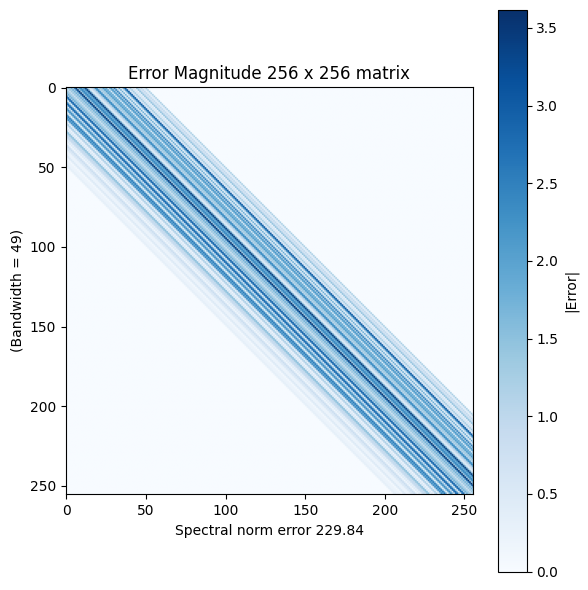

Matrix shape: (256, 256)
Spectral norm error: 2.298e+02


In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed and generate random complex polynomial of degree 99
np.random.seed(42)
degree = 99
P_real = np.random.randn(degree + 1)
P_imag = np.random.randn(degree + 1)
P_coeffs = P_real + 1j * P_imag

# Run GQSP_L_Test
n1 = 8
M_block, error, alpha, NU, P_of_L,Q_bad, P_bad = GQSP_L_Test(P_coeffs, n1)

# Compute modulus of the difference matrix
delta = alpha * M_block - P_of_L
mod_error = np.abs(delta)


# Plot heatmap using white-to-red colormap on log scale
plt.figure(figsize=(6, 6))
plt.imshow(mod_error, cmap='Blues', aspect='equal')
plt.colorbar(label='|Error|')
plt.title("Error Magnitude 256 x 256 matrix")
plt.ylabel("(Bandwidth = 49)")
plt.xlabel(f"Spectral norm error {round(float(error), 2)}")
plt.tight_layout()
plt.savefig("Heatmap_Big.png")
plt.show()

# Print error summary
print(f"Matrix shape: {M_block.shape}")
print(f"Spectral norm error: {error:.3e}")

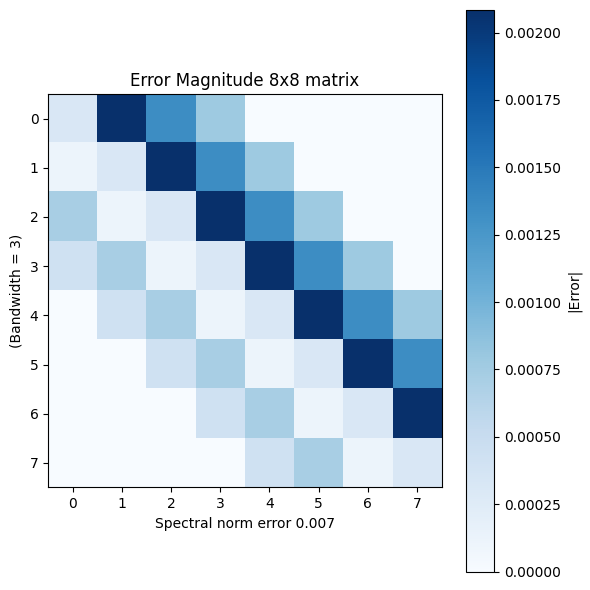

Matrix shape: (8, 8)
Spectral norm error: 6.996e-03


In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed and generate random complex polynomial of degree 99
np.random.seed(42)
degree = 7
P_real = np.random.randn(degree + 1)
P_imag = np.random.randn(degree + 1)
P_coeffs = P_real + 1j * P_imag

# Run GQSP_L_Test
n1 = 3
M_block, error, alpha, NU, P_of_L,Q_good, P_good = GQSP_L_Test(P_coeffs, n1)

# Compute modulus of the difference matrix
delta = alpha * M_block - P_of_L
mod_error = np.abs(delta)

# Plot heatmap using white-to-red colormap
plt.figure(figsize=(6, 6))
plt.imshow(mod_error, cmap='Blues', aspect='equal')
plt.colorbar(label='|Error|')
plt.title("Error Magnitude 8x8 matrix")
plt.xlabel(f"Spectral norm error {round(float(error), 4)}")
plt.ylabel("(Bandwidth = 3)")
plt.tight_layout()
plt.savefig("Heatmap_small.png")

plt.show()

# Print error summary
print(f"Matrix shape: {M_block.shape}")
print(f"Spectral norm error: {error:.3e}")



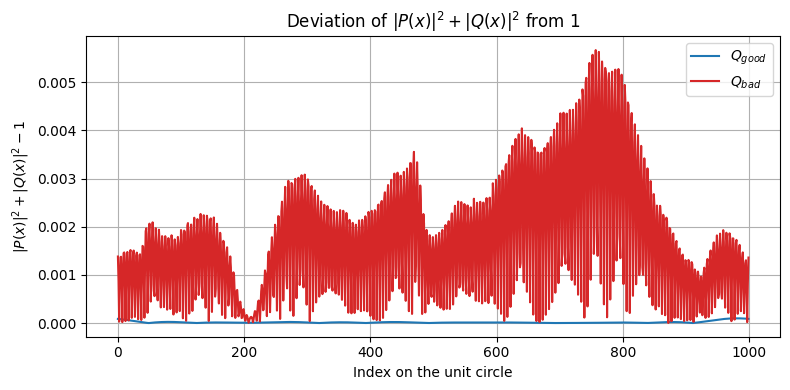

Max deviation with Q_good: 9.83220456189926e-05
Max deviation with Q_bad:  0.00566530335618487


In [118]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000
T = np.exp(2j * np.pi * np.linspace(0, 1, N, endpoint=False))

P_eval_good = np.polyval(P_good, T)
P_eval_bad = np.polyval(P_bad, T)
Q_eval_good = np.polyval(Q_good, T)
Q_eval_bad = np.polyval(Q_bad, T)

condition_good = np.abs(P_eval_good)**2 + np.abs(Q_eval_good)**2
condition_bad = np.abs(P_eval_bad)**2 + np.abs(Q_eval_bad)**2

plt.figure(figsize=(8, 4))
plt.plot(np.abs(condition_good - 1), label=r"$Q_{good}$", color="tab:blue")
plt.plot(np.abs(condition_bad - 1), label=r"$Q_{bad}$", color="tab:red")
plt.title(r"Deviation of $|P(x)|^2 + |Q(x)|^2$ from 1")
plt.xlabel("Index on the unit circle")
plt.ylabel(r"$|P(x)|^2 + |Q(x)|^2 - 1$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Q_deviation.png")
plt.show()

print("Max deviation with Q_good:", np.max(np.abs(condition_good - 1)))
print("Max deviation with Q_bad: ", np.max(np.abs(condition_bad - 1)))

## Error-Degree relation

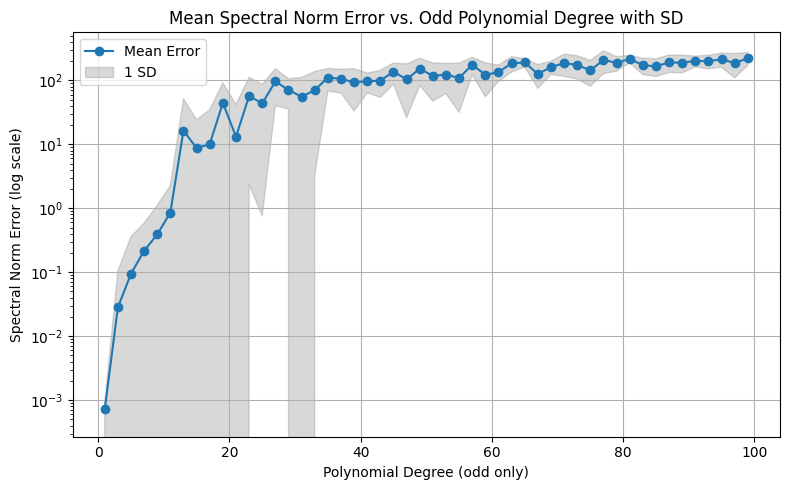

In [91]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
n1 = 8
trials = 10

# Store odd degrees and their error statistics
degrees = list(range(1, 100, 2))
mean_errors = []
std_errors = []

for degree in degrees:
    errors = []
    for _ in range(trials):
        P_real = np.random.randn(degree + 1)
        P_imag = np.random.randn(degree + 1)
        P_coeffs = P_real + 1j * P_imag

        M_block, error, alpha, NU, P_of_L, q, p = GQSP_L_Test(P_coeffs, n1)
        errors.append(error)
    mean_errors.append(np.mean(errors))
    std_errors.append(np.std(errors))

# Plot mean error with standard deviation shading
plt.figure(figsize=(8, 5))
mean_errors = np.array(mean_errors)
std_errors = np.array(std_errors)

plt.plot(degrees, mean_errors, marker='o', label='Mean Error')
plt.fill_between(degrees,
                 mean_errors - std_errors,
                 mean_errors + std_errors,
                 color='gray', alpha=0.3,
                 label='1 SD')

plt.yscale('log')
plt.xlabel("Polynomial Degree (odd only)")
plt.ylabel("Spectral Norm Error (log scale)")
plt.title("Mean Spectral Norm Error vs. Odd Polynomial Degree with SD")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


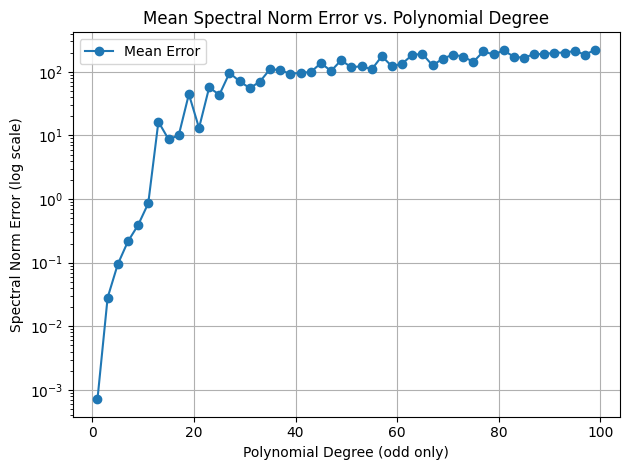

In [116]:
plt.plot(degrees, mean_errors, marker='o', label='Mean Error')


plt.yscale('log')
plt.xlabel("Polynomial Degree (odd only)")
plt.ylabel("Spectral Norm Error (log scale)")
plt.title("Mean Spectral Norm Error vs. Polynomial Degree")
plt.grid(True)
plt.legend()
plt.tight_layout()
# Save the figure as PDF
plt.savefig("spectral_error_vs_degree.png")
plt.show()


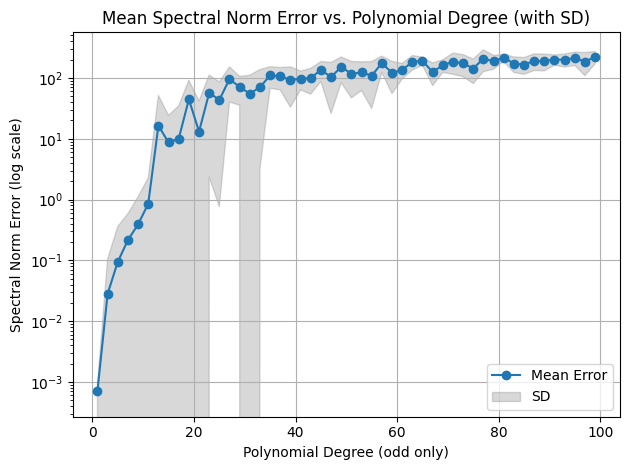

In [117]:
plt.plot(degrees, mean_errors, marker='o', label='Mean Error')
plt.fill_between(degrees,
                 mean_errors - std_errors,
                 mean_errors + std_errors,
                 color='gray', alpha=0.3,
                 label='SD')

plt.yscale('log')
plt.xlabel("Polynomial Degree (odd only)")
plt.ylabel("Spectral Norm Error (log scale)")
plt.title("Mean Spectral Norm Error vs. Polynomial Degree (with SD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
# Save the figure as PDF
plt.savefig("spectral_error_vs_degree_sd.png")
plt.show()
